In [1]:
import numpy as np
import tensorflow as tf

In [2]:
# input data
def get_data():
    """ Generate 3D saddle. """
    N = 1000
    X = np.random.random((N, 2)) * 4 - 2
    Y = X[:, 0] * X[:, 1]
    return X, Y
X, Y = get_data()
Y = Y.reshape((-1, 1)) # for regression, where has one dimension only
N, D = X.shape
_, K = Y.shape

In [22]:
# Start building up the tf graph
tf.reset_default_graph()
# Add tf placeholders for data
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=(None, D), name='x')
    y = tf.placeholder(tf.float32, shape=(None, K), name='y')
# Add and initialize tf variables for the neural network weights
M1 = 100
M2 = 200
with tf.name_scope('weights'):
    '''
    # Lowest level initialisation (explicit)
    W1_init = np.random.randn(D, M1) * np.sqrt(2 / (D + M1)) # Glorot normalisation
    W2_init = np.random.randn(M1, M2) * np.sqrt(2 / (M1 + M2))
    W3_init = np.random.randn(M2, K) * np.sqrt(2 / (M2 + K))
    w1 = tf.Variable(W1_init.astype(np.float32), name='w1')
    w2 = tf.Variable(W2_init.astype(np.float32), name='w2')
    w3 = tf.Variable(W3_init.astype(np.float32), name='w3')
    b1 = tf.Variable(tf.zeros(M1), name='b1')
    b2 = tf.Variable(tf.zeros(M2), name='b2')
    b3 = tf.Variable(tf.zeros(K), name='b3')
    # Highest level, with tf.get_variable. Deprecated in TF2!
    w1 = tf.get_variable(name='w1', shape=[D, M1], initializer=tf.glorot_normal_initializer)
    w2 = tf.get_variable(name='w1', shape=[M1, M2], initializer=tf.glorot_normal_initializer)
    w3 = tf.get_variable(name='w3', shape=[M2, K], initializer=tf.glorot_normal_initializer)
    b1 = tf.get_variable(name='b1', shape=M1, initializer=tf.zeros_initializer)
    b2 = tf.get_variable(name='b2', shape=M2, initializer=tf.zeros_initializer)
    b3 = tf.get_variable(name='b3', shape=K, initializer=tf.zeros_initializer)
    '''
    # High level initialization (with tf initializers)
    w1 = tf.Variable(tf.glorot_normal_initializer()(shape=[D, M1]), name='w1')
    w2 = tf.Variable(tf.glorot_normal_initializer()(shape=[M1, M2]), name='w2')
    w3 = tf.Variable(tf.glorot_normal_initializer()(shape=[M2, K]), name='w3')
    b1 = tf.Variable(tf.zeros_initializer()(shape=M1), name='b1')
    b2 = tf.Variable(tf.zeros_initializer()(shape=M2), name='b2')
    b3 = tf.Variable(tf.zeros_initializer()(shape=K), name='b3')

In [23]:
# Define the neural network layers (z's below are logits)
with tf.name_scope('logits'):
    z1 = tf.add(tf.matmul(x, w1), b1, name='z1')
    z2 = tf.add(tf.matmul(tf.nn.relu(z1), w2), b2, name='z2')
    z3 = tf.add(tf.matmul(tf.nn.relu(z2), w3), b3, name='z3')
# Define cost function and metric
with tf.name_scope('metrics'):
    mse = tf.reduce_mean(tf.pow(z3 - y, 2), name='mse')
    mae = tf.reduce_mean(tf.abs(z3 - y), name='mae')

In [24]:
# Visualize the tf graph with TensorBoard
# https://www.tensorflow.org/guide/summaries_and_tensorboard
%load_ext tensorboard.notebook
logdir = './out/tf_logs/'
with tf.Session() as session:
    writer = tf.summary.FileWriter(logdir=logdir, graph=session.graph)
    tf.global_variables_initializer().run()
%tensorboard --logdir tf_logs/

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Reusing TensorBoard on port 6006 (pid 44637), started -1 day, 23:01:09 ago. (Use '!kill 44637' to kill it.)

In [25]:
# 1. Simple Gradient Descent
# Note 1: we want to call .minimize() before the for loop, otherwise it is very inefficient.
# Note 2: here we can run the initializer before calling .minimize(), because the GradientDescent does not
# introduces additional variables.
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(mse)
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.792, mae: 1.013
10 mse: 1.427, mae: 0.888
20 mse: 1.124, mae: 0.773
30 mse: 0.871, mae: 0.665
40 mse: 0.655, mae: 0.565
50 mse: 0.479, mae: 0.474
60 mse: 0.342, mae: 0.397
70 mse: 0.244, mae: 0.335
80 mse: 0.178, mae: 0.289
90 mse: 0.138, mae: 0.259
100 mse: 0.113, mae: 0.241


In [26]:
# 2. RMSProp. 
# Here the variable initializer MUST be called after .minimize(), because RMSProp creates
# additional variables ("accumulators") to store the moving averages of gradients and squared gradients.
optimizer = tf.train.RMSPropOptimizer(0.01, decay=0.9).minimize(mse)
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.931, mae: 1.057
10 mse: 1.439, mae: 0.892
20 mse: 0.837, mae: 0.649
30 mse: 0.244, mae: 0.329
40 mse: 0.083, mae: 0.216
50 mse: 0.077, mae: 0.212
60 mse: 0.134, mae: 0.279
70 mse: 0.085, mae: 0.230
80 mse: 0.072, mae: 0.211
90 mse: 0.106, mae: 0.262
100 mse: 0.146, mae: 0.315


In [27]:
# 3a. Gradient Descent with simple momentum.
# Here the variable initializer MUST be called after .minimize(), because MomentumOptimizer creates
# additional variables ("accumulators") to store the cumulated gradients.
optimizer = tf.train.MomentumOptimizer(0.01, momentum=0.99).minimize(mse)
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.880, mae: 1.044
10 mse: 0.483, mae: 0.475
20 mse: 0.654, mae: 0.709
30 mse: 0.513, mae: 0.503
40 mse: 0.083, mae: 0.231
50 mse: 0.126, mae: 0.299
60 mse: 0.382, mae: 0.413
70 mse: 0.124, mae: 0.297
80 mse: 0.048, mae: 0.171
90 mse: 0.188, mae: 0.303
100 mse: 0.049, mae: 0.172


In [28]:
# 3b. Gradient Descent with Nesterov momentum.
optimizer = tf.train.MomentumOptimizer(0.01, momentum=0.99, use_nesterov=True).minimize(mse)
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.766, mae: 1.008
10 mse: 0.254, mae: 0.337
20 mse: 0.369, mae: 0.539
30 mse: 0.275, mae: 0.343
40 mse: 0.113, mae: 0.280
50 mse: 0.058, mae: 0.173
60 mse: 0.036, mae: 0.153
70 mse: 0.023, mae: 0.111
80 mse: 0.013, mae: 0.088
90 mse: 0.007, mae: 0.063
100 mse: 0.006, mae: 0.060


In [29]:
# 4. RMSProp wih momentum.
optimizer = tf.train.RMSPropOptimizer(0.01, decay=0.9, momentum=0.99).minimize(mse)
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 2.055, mae: 1.096
10 mse: 0.505, mae: 0.482
20 mse: 0.193, mae: 0.361
30 mse: 0.168, mae: 0.340
40 mse: 0.067, mae: 0.188
50 mse: 0.303, mae: 0.460
60 mse: 0.111, mae: 0.255
70 mse: 0.078, mae: 0.208
80 mse: 0.047, mae: 0.169
90 mse: 0.026, mae: 0.136
100 mse: 0.011, mae: 0.084


In [30]:
# 5. Adam.
optimizer = tf.train.AdamOptimizer(0.01, beta1=0.9, beta2=0.99).minimize(mse)
epochs = 100
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    for e in range(epochs):
        session.run(optimizer, feed_dict={x:X, y:Y})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.838, mae: 1.030
10 mse: 0.180, mae: 0.270
20 mse: 0.050, mae: 0.170
30 mse: 0.031, mae: 0.139
40 mse: 0.011, mae: 0.081
50 mse: 0.004, mae: 0.043
60 mse: 0.006, mae: 0.062
70 mse: 0.002, mae: 0.029
80 mse: 0.001, mae: 0.021
90 mse: 0.001, mae: 0.026
100 mse: 0.001, mae: 0.020


In [35]:
# 6. SGD
epochs = 100
batch_sz = 100
batches = N // batch_sz
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("%d mse: %.3f, mae: %.3f" % (0, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(mse)
    for e in range(epochs):
        for b in range(batches):
            X_b = X[batch_sz*b:batch_sz*(b+1),]
            Y_b = Y[batch_sz*b:batch_sz*(b+1),]
            session.run(optimizer, feed_dict={x:X_b, y:Y_b})
        if (e+1) % 10 == 0:
            print("%d mse: %.3f, mae: %.3f" % (e+1, session.run(mse, feed_dict={x:X, y:Y}), session.run(mae, feed_dict={x:X, y:Y})))

0 mse: 1.839, mae: 1.031
10 mse: 0.121, mae: 0.246
20 mse: 0.079, mae: 0.217
30 mse: 0.075, mae: 0.212
40 mse: 0.073, mae: 0.208
50 mse: 0.071, mae: 0.205
60 mse: 0.069, mae: 0.201
70 mse: 0.066, mae: 0.198
80 mse: 0.064, mae: 0.194
90 mse: 0.062, mae: 0.190
100 mse: 0.059, mae: 0.186


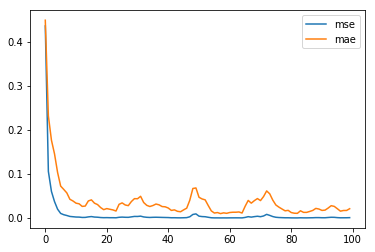

In [41]:
# With keras API
import matplotlib.pyplot as plt
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=M1, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=M2, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.99),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[tf.keras.metrics.mean_absolute_error]
)
r = model.fit(X, Y, epochs=100, batch_size=100, verbose=0)
plt.plot(r.history['loss'], label='mse')
plt.plot(r.history['mean_absolute_error'], label='mae')
plt.legend()
plt.show()